# Calculating virtual partical trajectories from ocean-only (uncoupled)  and ocean-wave (coupled) model simulations for the Mediterranean Sea

## 1. General settings
Can nearly always stay untouched

### 1.1 Load Modules

In [1]:
from glob import glob
from datetime import timedelta, datetime
import math

from parcels import (FieldSet, ParticleSet,
                     JITParticle, ScipyParticle,
                     AdvectionRK4,
                     Variable, Field, VectorField)
import xarray as xr
import numpy as np

%matplotlib inline

 ### 1.2 Define general custom functions

In [2]:
# DEFINE ALTERNATIVE TO USE NP.ARANGE
#
# from https://stackoverflow.com/questions/50299172/python-range-or-numpy-arange-with-end-limit-include
# (code posted by Markus Dutschke on Aug 2nd 2019, last accessed on Dec 6th 2023)
#
# WHY using it? 
# In principal, values are generated within the half-open interval [start, stop)
# (in other words, the interval including start but excluding stop). 
# Yet, unfortunately, when using a non-integer step (such as 0.1), 
# the results of np.arange are often not consistent. 
# Specifically, they sometimes do include the stop value.
# It is better to use the following function based on numpy.linspace for these cases

def cust_range(*args, rtol=1e-05, atol=1e-08, include=[True, False]):
    """
    Combines numpy.arange and numpy.isclose to mimic
    open, half-open and closed intervals.
    Avoids also floating point rounding errors as with
    >>> numpy.arange(1, 1.3, 0.1)
    array([1. , 1.1, 1.2, 1.3])

    args: [start, ]stop, [step, ]
        as in numpy.arange
    rtol, atol: floats
        floating point tolerance as in numpy.isclose
    include: boolean list-like, length 2
        if start and end point are included
    """
    # process arguments
    if len(args) == 1:
        start = 0
        stop = args[0]
        step = 1
    elif len(args) == 2:
        start, stop = args
        step = 1
    else:
        assert len(args) == 3
        start, stop, step = tuple(args)

    # determine number of segments
    n = (stop-start)/step + 1

    # do rounding for n
    if np.isclose(n, np.round(n), rtol=rtol, atol=atol):
        n = np.round(n)

    # correct for start/end is exluded
    if not include[0]:
        n -= 1
        start += step
    if not include[1]:
        n -= 1
        stop -= step

    return np.linspace(start, stop, int(n))

def crange(*args, **kwargs):
    return cust_range(*args, **kwargs, include=[True, True])

def orange(*args, **kwargs):
    return cust_range(*args, **kwargs, include=[True, False])

print("crange(1, 1.3, 0.1) >>>", crange(1, 1.3, 0.1))
print("orange(1, 1.3, 0.1) >>>", orange(1, 1.3, 0.1))
print("crange(0.0, 0.6, 0.2) >>>", crange(0.0, 0.6, 0.2))
print("orange(0.0, 0.6, 0.2) >>>", orange(0.0, 0.6, 0.2))

crange(1, 1.3, 0.1) >>> [1.  1.1 1.2 1.3]
orange(1, 1.3, 0.1) >>> [1.  1.1 1.2]
crange(0.0, 0.6, 0.2) >>> [0.  0.2 0.4 0.6]
orange(0.0, 0.6, 0.2) >>> [0.  0.2 0.4]


## 2. Custom settings Parcels
!!! IMPORTANT: need to be checked/adjusted before every execution !!!

### 2.1 Define input paths

In [3]:
############################

# set key to 'uncoupled', 'uncoupled_sd', 'coupled_nosd', or 'coupled_sd'
key_input = "uncoupled"

# define whether Lagrangian velocity is sampled (key_sample_velocity = True)
key_sample_velocity = True

############################

datapath = "/Users/siren/Data/IMMERSE/"

gridpath = (datapath + "domain/fgrid.nc")

if (key_input == "uncoupled") or (key_input == "uncoupled_sd"):
    filepaths_u = sorted(glob(datapath + "surface_TKE_UNC/MED24_OBC_1d*_grid_U.nc"))
    filepaths_v = sorted(glob(datapath + "surface_TKE_UNC/MED24_OBC_1d*_grid_V.nc"))
    if key_input == "uncoupled":
        key_stokes = False
        print("calculate trajectories for uncoupled simulation without additional consideration of Stokes drift")
    elif key_input == "uncoupled_sd":
        key_stokes = True
        filepaths_usd = sorted(glob(datapath + "surface_TKE_CO/MED24_OBC_1d*_grid_U.nc"))
        filepaths_vsd = sorted(glob(datapath + "surface_TKE_CO/MED24_OBC_1d*_grid_V.nc"))
        print("calculate trajectories for uncoupled simulation without additional consideration of Stokes drift")

elif (key_input == "coupled_nosd") or (key_input == "coupled_sd"):
    filepaths_u = sorted(glob(datapath + "surface_TKE_CO/MED24_OBC_1d*_grid_U.nc"))
    filepaths_v = sorted(glob(datapath + "surface_TKE_CO/MED24_OBC_1d*_grid_V.nc"))
    if key_input == "coupled_nosd":
        key_stokes = False
        print("calculate trajectories for coupled simulation without explicit consideration of Stokes drift")
    elif key_input == "coupled_sd":
        key_stokes = True
        filepaths_usd = filepaths_u
        filepaths_vsd = filepaths_v
        print("calculate trajectories for coupled simulation with explicit consideration of Stokes drift")

else:
    print("no (valid) key_input defined")

calculate trajectories for uncoupled simulation without additional consideration of Stokes drift


### 2.2 Define Particle release grid

In [4]:
############################

release_name = "GulfOfLion"

tstart_release = 0 # in time steps of input data set after start of input data set (here: days)
deltat_release = 5 # release from the same set of locations every deltat_release time steps
tend_release = 365 # in time steps of input data set after start of input data set
times_convert = 86400 # time step of input data in seconds

############################

lonmin = 3
lonmax = 5.6
latmin = 42.1
latmax = 43.5
step = 0.2 #(appr. every 5th grid cell)
    
lons, lats = np.meshgrid(crange(lonmin, lonmax, step),
                         crange(latmin, latmax, step))
n_releasepos = lons.shape[0]*lons.shape[1]
n_particles = n_releasepos * ((tend_release-tstart_release)/deltat_release)
print("maximum number of release positions (including land):", n_releasepos)
print("maximum number of particles (including land):", int(n_particles))

maximum number of release positions (including land): 112
maximum number of particles (including land): 8176


### 2.3 Define Lagrangian trajectory integration parameters

In [5]:
############################

tint = 30 # in days
deltat = 25 # in minutes
# How to chose deltat (Schmidt et al., 2021):
### The time step dt should be small enough that particles do not skip grid cells
### and thereby miss characteristic oceanographic features. 
### Due to trade-off between accuracy of time stepping and computation time, the integration
### time step dt was chosen such that particles stay in one model grid cell for at least 2dt
### Therefore, a time step dt can be calculated following dt<dsmin/(vmax⋅2)
### where dsmin is the smallest edge of all grid cells in the domain and
### vmax is the largest horizontal velocity.
### assume vmax = 1m/s, dsmin = 1/24 = 3000 m : dt < (3000 / 2)s = 1500 s = 25 min 
### (at 45N - northern boundary MedSea - 1deg lon is appr. 79km -> 1/24 deg = 3300m;
### 1 deg lat is 111km)

pclass = JITParticle 
# can be JITParticle or ScipyParticle

#############################

### 2.4 Define Lagrangian trajectory output

In [6]:
# DEFINE LAGRANGIAN TRAJECTORY OUTPUT

############################

outdt = 1 #in days
procpath = "/Users/siren/IMMERSE_waves/develop-mac/data/publish_IMMERSE/"

############################

if key_input == "uncoupled":
    outpath = (procpath + "Parcels_CalcTraj_Data-uncoupled_Release-" + release_name)
if key_input == "uncoupled_sd":
    outpath = (procpath + "Parcels_CalcTraj_Data-uncoupled-sd_Release-" + release_name)
elif key_input == "coupled_nosd":
    outpath = (procpath + "Parcels_CalcTraj_Data-coupled-nosd_Release-" + release_name)
elif key_input == "coupled_sd":
    outpath = (procpath + "Parcels_CalcTraj_Data-coupled-sd_Release-" + release_name)

## 3. Execution of Parcels simulation
Under normal circumstances, nothing needs to be changed in this section

### 3.1 Create custom Parcels functions

In [7]:
def create_fieldset(keystokes):
    
    filenames = {'U': {'lon': gridpath, 'lat': gridpath, 'data': filepaths_u},
                 'V': {'lon': gridpath, 'lat': gridpath, 'data': filepaths_v}}
    variables = {'U': 'vozocrtx',
                 'V': 'vomecrty'}
    dimensions = {'U': {'lon': 'glamf', 'lat': 'gphif', 'time': 'time_counter'},
                  'V': {'lon': 'glamf', 'lat': 'gphif', 'time': 'time_counter'}}
    fieldset = FieldSet.from_nemo(filenames, variables, dimensions,
                                  mesh='spherical',
                                  allow_time_extrapolation=False,time_periodic=False)
    
    if keystokes == True:
        filenames_sd = {'U': {'lon': gridpath, 'lat': gridpath, 'data': filepaths_usd},
                        'V': {'lon': gridpath, 'lat': gridpath, 'data': filepaths_vsd}}
        variables_sd = {'U': 'usd',
                        'V': 'vsd'}
        fieldset_sd = FieldSet.from_nemo(filenames_sd, variables_sd, dimensions,
                                         mesh='spherical',
                                         allow_time_extrapolation=False,
                                         time_periodic=False)
        fieldset_sum = FieldSet(U=fieldset.U+fieldset_sd.U,
                                V=fieldset.V+fieldset_sd.V)
        fieldset_use = fieldset_sum
    elif keystokes == False:
        fieldset_use = fieldset
            
    return fieldset_use

Kernels partially adopted and modified from https://github.com/OceanParcels/Parcelsv2.0PaperNorthSeaScripts

In [8]:
class BeachParticle(pclass):
    # beached : 0 sea, 1 beached, 2 after non-beach dyn
    beached = Variable("beached", dtype=np.int64, initial=2)

In [9]:
class BeachCurrentParticle(pclass):
    # beached : 0 sea, 1 beached, 2 after non-beach dyn
    beached = Variable("beached", dtype=np.int64, initial=0)
    U = Variable("U", dtype=np.float32, initial=np.nan)
    V = Variable("V", dtype=np.float32, initial=np.nan)

In [10]:
def AdvectionRK4(particle, fieldset, time):
    if particle.beached == 0:
        (u1, v1) = fieldset.UV[time, particle.depth, particle.lat, particle.lon, particle]
        lon1, lat1 = (particle.lon + u1*.5*particle.dt, particle.lat + v1*.5*particle.dt)

        (u2, v2) = fieldset.UV[time + .5 * particle.dt, particle.depth, lat1, lon1, particle]
        lon2, lat2 = (particle.lon + u2*.5*particle.dt, particle.lat + v2*.5*particle.dt)

        (u3, v3) = fieldset.UV[time + .5 * particle.dt, particle.depth, lat2, lon2, particle]
        lon3, lat3 = (particle.lon + u3*particle.dt, particle.lat + v3*particle.dt)

        (u4, v4) = fieldset.UV[time + particle.dt, particle.depth, lat3, lon3, particle]
        particle.lon += (u1 + 2*u2 + 2*u3 + u4) / 6. * particle.dt
        particle.lat += (v1 + 2*v2 + 2*v3 + v4) / 6. * particle.dt
        particle.beached = 2

In [11]:
def SampleUV(particle, fieldset, time):
    # attention: samples particle velocity in deg/s and needs to be converted to m/s
    particle.U, particle.V = fieldset.UV[time, particle.depth, particle.lat, particle.lon, particle]

In [12]:
def BeachTesting(particle, fieldset, time):
    if particle.beached == 2:
        (u, v) = fieldset.UV[time, particle.depth, particle.lat, particle.lon, particle]
        # if velocity threshold ist set to 1e-8 (suggestion Christian) artificial beaching occurs -> do NOT do that
        if math.fabs(u) < 1e-14 and math.fabs(v) < 1e-14:
            particle.beached = 1
            print("Particle [%d] beached !! (%g %g %g %g)" % (particle.id, particle.lon, particle.lat, particle.depth, particle.time))
        else:
            particle.beached = 0

In [13]:
def DeleteParticle(particle, fieldset, time):
    if particle.beached == 1:
        particle.delete()
        print("Particle [%d] deleted !! (%g %g %g %g)" % (particle.id, particle.lon, particle.lat, particle.depth, particle.time))

In [14]:
def PlotParticleSet(pset,fieldset):
    plotstep=4
    pset.show(field=fieldset.U,
              domain={"N":(latmax+plotstep/2),"S":(latmin-plotstep),
                      "E": (lonmax+plotstep), "W":(lonmin-plotstep)})

### 3.2 Determine exact particle release positions (mask land positions)

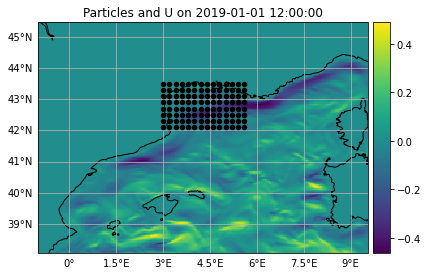

maximum number of release positions (including land): 112



INFO: Compiled ArrayBeachParticleBeachTestingDeleteParticle ==> /var/folders/bd/ct5yrfy51z7bdshm97c2w2nc0000gp/T/parcels-502/lib311da8ed82dd0b15da0562d0c8d6b86a_0.so


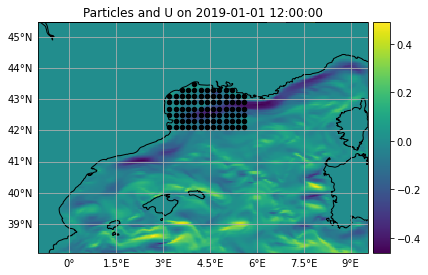

actual number of release positions (excluding land): 87
actual number of particles: 6351.0


In [17]:
# release particles on predefined uniform grid, including land grid points
fieldset_init = create_fieldset(keystokes=False)
pset_init = ParticleSet(fieldset=fieldset_init,
                        pclass=BeachParticle,
                        lon=lons, lat=lats, time=0)
pset_init.populate_indices()
PlotParticleSet(pset_init,fieldset_init)
print("maximum number of release positions (including land):",pset_init.lon.size)
print()
lons_prelim = pset_init.lon
lats_prelim = pset_init.lat

# perform a "fake" integration to determine and delete particles released on land
## by making use of beach-testing and deleting kernels
## (without advection kernel)
kernels_init = pset_init.Kernel(BeachTesting) + pset_init.Kernel(DeleteParticle)
pset_init.execute(kernels_init, dt=0)
PlotParticleSet(pset_init,fieldset_init)

# retrieve lon and lats from all ocean release positions
print("actual number of release positions (excluding land):", pset_init.lon.size)
print("actual number of particles:",
      pset_init.lon.size * ((tend_release-tstart_release)/deltat_release))
lons_use = pset_init.lon
lats_use = pset_init.lat

### 3.3 Perform trajectory integration and save trajectory data

In [20]:
%%time
for times in range(tstart_release, tend_release, deltat_release):
    
    if (key_sample_velocity == True):
        pclass_main = BeachCurrentParticle
        outpath_ending = "m_Sample-UV.nc"
    else:
        pclass_main=BeachParticle
        outpath_ending = "m.nc"
  
    ## create new clean particle set (including new clean fieldset)
    fieldset_main = create_fieldset(keystokes=key_stokes)
    pset_main = ParticleSet(fieldset=fieldset_main,
                            pclass=pclass_main,
                            lon=lons_use, lat=lats_use,
                            time=times*times_convert)   
    pset_main.populate_indices()
    
    ## define output
    ### ensure depth is not stored in trajectory output (depth not necessary for 2D calculations)
    pset_main.set_variable_write_status("depth", False) 
    outpath_final = (outpath + "-t" + str(times) 
                     + "_Integrate-fw-d" + str(tint) + "-dt" + str(deltat) 
                     + outpath_ending)
    outfile_final = pset_main.ParticleFile(outpath_final, 
                                           outputdt=timedelta(days=outdt))
  
    ## advect particle
    ## do not delete potentially beached particles, but keep them for statistics
    if (key_sample_velocity == True):
        kernels_main = (pset_main.Kernel(AdvectionRK4) + pset_main.Kernel(BeachTesting) 
                        + pset_main.Kernel(SampleUV))
    else:
        kernels_main = (pset_main.Kernel(AdvectionRK4) + pset_main.Kernel(BeachTesting))
    pset_main.execute(kernels_main,
                      runtime=timedelta(days=tint),
                      dt=timedelta(minutes=deltat),
                      output_file=outfile_final)
        
    outfile_final.export()
    outfile_final.close()
    
    pset_main.set_variable_write_status("depth", True) # somehow needed, otherwise next pset can not be build

INFO: Compiled ArrayBeachCurrentParticleAdvectionRK4BeachTestingSampleUV ==> /var/folders/bd/ct5yrfy51z7bdshm97c2w2nc0000gp/T/parcels-502/lib8a6a359c85129c5aa10a00a79fd7b9d4_0.so
INFO: Compiled ArrayBeachCurrentParticleAdvectionRK4BeachTestingSampleUV ==> /var/folders/bd/ct5yrfy51z7bdshm97c2w2nc0000gp/T/parcels-502/libaa326ac0c4705f71df0412d25fc37506_0.so
INFO: Compiled ArrayBeachCurrentParticleAdvectionRK4BeachTestingSampleUV ==> /var/folders/bd/ct5yrfy51z7bdshm97c2w2nc0000gp/T/parcels-502/libe1e2c5e9b9114a15b0908b7069e7ddb3_0.so
INFO: Compiled ArrayBeachCurrentParticleAdvectionRK4BeachTestingSampleUV ==> /var/folders/bd/ct5yrfy51z7bdshm97c2w2nc0000gp/T/parcels-502/libb641939efae63f0b1a7275a03de3bac4_0.so
INFO: Compiled ArrayBeachCurrentParticleAdvectionRK4BeachTestingSampleUV ==> /var/folders/bd/ct5yrfy51z7bdshm97c2w2nc0000gp/T/parcels-502/lib14d0719c90d6f43347444cf981150f6d_0.so
INFO: Compiled ArrayBeachCurrentParticleAdvectionRK4BeachTestingSampleUV ==> /var/folders/bd/ct5yrfy51z7b

INFO: Compiled ArrayBeachCurrentParticleAdvectionRK4BeachTestingSampleUV ==> /var/folders/bd/ct5yrfy51z7bdshm97c2w2nc0000gp/T/parcels-502/liba03b71b6930a4434b6020e4015988237_0.so
INFO: Compiled ArrayBeachCurrentParticleAdvectionRK4BeachTestingSampleUV ==> /var/folders/bd/ct5yrfy51z7bdshm97c2w2nc0000gp/T/parcels-502/lib85eda725079b7ecd50eae3de8dc2560b_0.so
INFO: Compiled ArrayBeachCurrentParticleAdvectionRK4BeachTestingSampleUV ==> /var/folders/bd/ct5yrfy51z7bdshm97c2w2nc0000gp/T/parcels-502/lib08fcf6ae878d8e32981eebe620957efc_0.so
INFO: Compiled ArrayBeachCurrentParticleAdvectionRK4BeachTestingSampleUV ==> /var/folders/bd/ct5yrfy51z7bdshm97c2w2nc0000gp/T/parcels-502/lib24dd7b747e0a2c8dab00b0c4cf7c923a_0.so
INFO: Compiled ArrayBeachCurrentParticleAdvectionRK4BeachTestingSampleUV ==> /var/folders/bd/ct5yrfy51z7bdshm97c2w2nc0000gp/T/parcels-502/lib3e53b3b3f7aa09e1ba4ef4f706170c97_0.so
INFO: Compiled ArrayBeachCurrentParticleAdvectionRK4BeachTestingSampleUV ==> /var/folders/bd/ct5yrfy51z7b

CPU times: user 32min 55s, sys: 1min 32s, total: 34min 28s
Wall time: 37min 7s
